In [10]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

!pip install sciann 
!git clone https://github.com/sciann/sciann-applications.git
!cp /content/sciann-applications/SciANN-Elasticity/sciann_datagenerator.py /content/sciann_datagenerator.py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'sciann-applications' already exists and is not an empty directory.


In [11]:
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt
import sciann as sn 
from sciann_datagenerator import * 

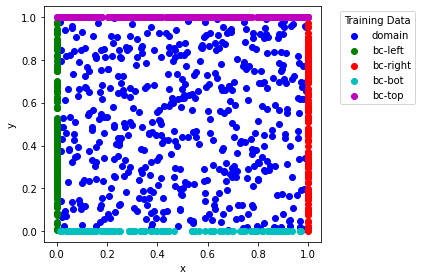

In [12]:
dg = DataGeneratorXY([0.,1.], [0.,1.], num_sample=1000)
dg.plot_data()

In [13]:
lmbd = 1.0
mu = 0.5
Q = 4.0

In [14]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh')
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')
Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

C11 = (2*mu + lmbd)
C12 = lmbd
C33 = 2*mu

Exx = sn.diff(Uxy, x)
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

c1 = sn.Tie(Sxx, Exx*C11 + Eyy*C12)
c2 = sn.Tie(Syy, Eyy*C11 + Exx*C12)
c3 = sn.Tie(Sxy, Exy*C33)

Fx = - lmbd*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - mu*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 8*mu*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)

Fy = lmbd*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - mu*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 6*Q*mu*y**2*sn.sin(pi*x)

Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy

BC_left_1 = (x==0.)*(Vxy)
BC_left_2 = (x==0.)*Sxx

BC_right_1 = (x==1.)*(Vxy)
BC_right_2 = (x==1.)*Sxx

BC_bot_1 = (y==0.)*(Uxy)
BC_bot_2 = (y==0.)*(Vxy)

BC_top_1 = (y==1.)*(Uxy)
BC_top_2 = (y==1.)*(Syy - (lmbd+2*mu)*Q*sn.sin(pi*x))


targets = [Lx, Ly, c1, c2, c3, 
           BC_left_1, BC_left_2, 
           BC_right_1, BC_right_2, 
           BC_bot_1, BC_bot_2, 
           BC_top_1, BC_top_2]

In [15]:
dg = DataGeneratorXY(X=[0.,1.], Y=[0.,1.], 
                     num_sample=10000,
                     targets=5*['domain'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

input_data, target_data = dg.get_data()

In [16]:
m = sn.SciModel([x, y], targets)

In [17]:
m.train(input_data, target_data, batch_size=100, epochs=100)


Total samples: 12500 
Batch size: 100 
Total batches: 125 

Epoch 1/100
125/125 [==============================] - 12s 29ms/step - batch: 62.0000 - size: 100.0000 - loss: 1462.9531 - sub_10_loss: 1279.0629 - sub_11_loss: 163.7063 - sub_loss: 1.1247 - sub_2_loss: 1.5326 - sub_3_loss: 0.8340 - mul_49_loss: 0.2464 - mul_50_loss: 3.9341 - mul_51_loss: 0.2320 - mul_52_loss: 2.6532 - mul_53_loss: 0.0745 - mul_54_loss: 0.2081 - mul_55_loss: 0.3882 - mul_58_loss: 8.9563 - lr: 0.0010 - time: 12.2096
Epoch 2/100
125/125 [==============================] - 4s 31ms/step - batch: 62.0000 - size: 100.0000 - loss: 516.0377 - sub_10_loss: 454.4073 - sub_11_loss: 29.7474 - sub_loss: 1.8405 - sub_2_loss: 1.2291 - sub_3_loss: 6.8358 - mul_49_loss: 0.1133 - mul_50_loss: 6.6436 - mul_51_loss: 0.6251 - mul_52_loss: 5.8150 - mul_53_loss: 0.0759 - mul_54_loss: 0.2905 - mul_55_loss: 0.4388 - mul_58_loss: 7.9756 - lr: 0.0010 - time: 3.8663
Epoch 3/100
125/125 [==============================] - 4s 28ms/step - ba

In [18]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

In [19]:
u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])

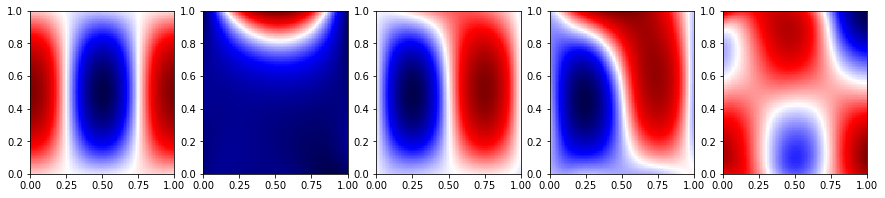

In [22]:
fig,ax = plt.subplots(1,5,figsize=(15,3))
ax[0].pcolor(x_test, y_test, u_test, cmap='seismic')
ax[1].pcolor(x_test, y_test, v_test, cmap='seismic')
ax[2].pcolor(x_test, y_test, sxx_test, cmap='seismic')
ax[3].pcolor(x_test, y_test, syy_test, cmap='seismic')
ax[4].pcolor(x_test, y_test, sxy_test, cmap='seismic')
plt.show()